### PREPARATION

In [ ]:
!pip install autokeras
!pip install tensorflow_addons

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow as tf
import autokeras as ak

In [ ]:
DATA_PATH = "/data/cicdata.csv"
LABEL_PATH = "/data/ciclabel.csv"

early_warning = pd.read_csv(DATA_PATH)
rotulos = pd.read_csv(LABEL_PATH)

init = 99
train = 560
test = 1484
cols = ["5_kurt_total_ips_origem", 
        "5_skw_total_ips_destino", 
        "5_voefficient_variation_total_pacotes"]

In [ ]:
x_train = early_warning[cols][init:train]
y_train = rotulos['maior_2'][init:train]

x_test = early_warning[cols][train:test]
y_test = rotulos['maior_2'][train:test]

x_train = x_train.fillna(-1)
x_test = x_test.fillna(-1)

### LOAD MODEL

In [ ]:
from tensorflow.keras.models import load_model

MODEL_PATH = "/models/cicmodel"

loaded_model = load_model(MODEL_PATH, custom_objects=ak.CUSTOM_OBJECTS, compile=False)
keras.utils.plot_model(loaded_model, show_shapes=True)

### RECONSTRUCTION

In [ ]:
Xtrain = x_train.values.reshape(x_train.shape[0], 1, x_train.shape[1])
X_pred_train = loaded_model.predict(Xtrain)
X_pred_train = pd.DataFrame(X_pred_train, columns=x_train.columns, index=x_train.index)
X_pred_train.index = x_train.index
X_pred_train

15/15 [==============================] - 7s 9ms/step


,5_kurt_total_ips_origem,5_skw_total_ips_destino,5_voefficient_variation_total_pacotes
99,1.970705,1.442229,2.318878
100,2.058901,1.380591,2.449877
101,2.058901,1.380591,2.449877
102,2.067334,1.373042,2.463308
103,1.977802,1.476137,2.286502
...,...,...,...
555,35.789024,6.417824,10.916689
556,35.771233,6.414857,10.912306
557,35.000889,6.284564,10.719995
558,35.301544,6.335470,10.795094


Text(0.5, 1.0, 'Modelo com novas features')

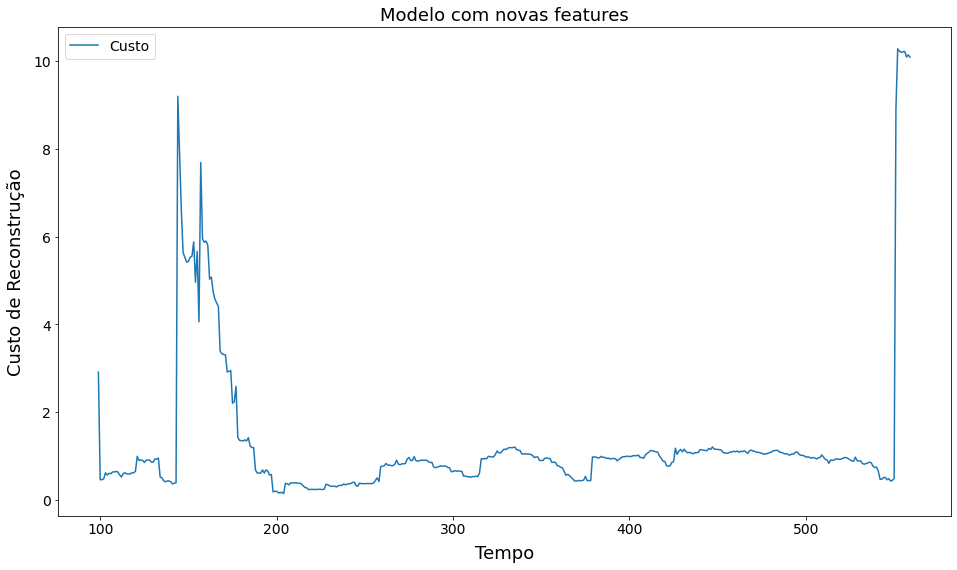

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(14)

ax.plot(np.mean(np.abs(X_pred_train-x_train), axis=1), label='Custo')
plt.xlabel("Tempo", fontsize=18, labelpad=8.0)
plt.ylabel("Custo de Reconstrução", fontsize=18, labelpad=8.0)
leg = ax.legend(prop={"size":14})

plt.title("Modelo com novas features", fontsize=18)

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

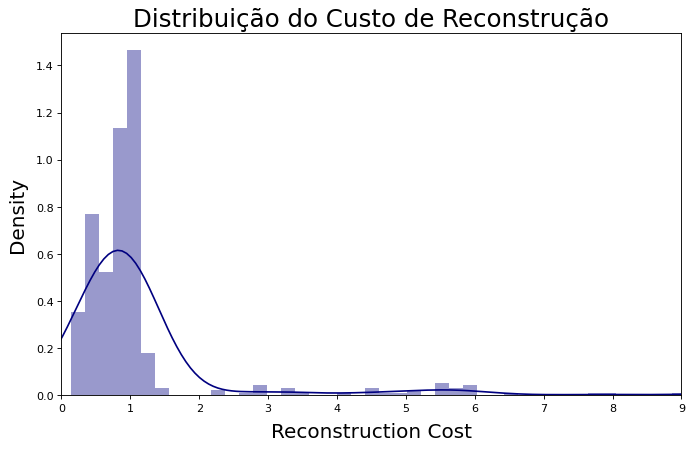

In [ ]:
scored_train = pd.DataFrame()
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-x_train), axis = 1)

plt.figure(figsize=(10,6), dpi=80)
plt.title('Distribuição do Custo de Reconstrução', fontsize=22)
sns.distplot(scored_train['Loss_mae'], bins = 50, kde=True, color = 'navy')
sns.set(font_scale=1.4)
plt.xlim([0.0,9])
plt.xlabel("Reconstruction Cost", fontsize=18, labelpad=8.0)
plt.ylabel("Density", fontsize=18, labelpad=8.0)

### TEST

In [ ]:
percentil = 97.9
threshold = np.percentile(scored_train['Loss_mae'], percentil)

Xtest = x_test.values.reshape(x_test.shape[0], 1, x_test.shape[1])
X_pred_test = loaded_model.predict(Xtest)
X_pred_test = pd.DataFrame(X_pred_test, columns=x_test.columns)

scored_test = pd.DataFrame()
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[2])
scored_test['Loss_mae'] = np.mean(np.abs(X_pred_test-Xtest), axis = 1)
scored_test['Anomaly'] = scored_test['Loss_mae'] > threshold
scored_test.tail()

concatenated = scored_test.copy()
concatenated.index = y_test.index
concatenated['label'] = y_test
concatenated['label'] = concatenated['label'].astype(int)
concatenated

In [ ]:
xticklabels=['Normal', 'Anomalia'] 
yticklabels=['Normal', 'Anomalia']
cm = confusion_matrix(concatenated['label'], concatenated['Anomaly'])
s = sns.heatmap(cm, annot=True, fmt='d', xticklabels=xticklabels, yticklabels=yticklabels)
s.set(xlabel='Valor Predito', ylabel='Valor Real', title=f"Threshold {threshold}")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(concatenated["label"], concatenated["Anomaly"], digits=3))

              precision    recall  f1-score   support

           0      0.870     0.978     0.921       801
           1      0.250     0.049     0.082       123

    accuracy                          0.854       924
   macro avg      0.560     0.513     0.501       924
weighted avg      0.787     0.854     0.809       924



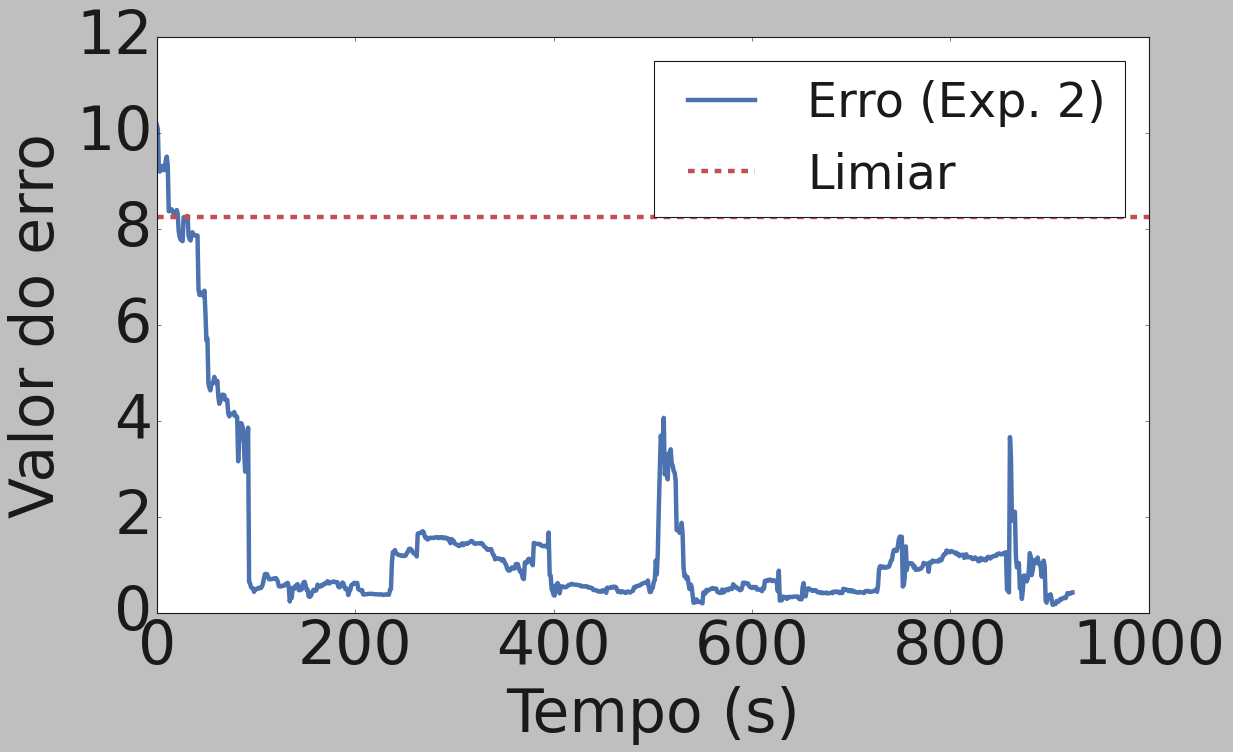

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.style.use('classic')

fsize = 54

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(fsize)

ax.plot(np.mean(np.abs(X_pred_test-Xtest), axis=1), linewidth=4, label='Erro (Exp. 2)')

plt.axhline(y=threshold, linewidth=4,color="r", linestyle="--", label="Limiar")

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xlabel("Tempo (s)", fontsize=fsize, labelpad=8.0)
plt.ylabel("Valor do erro", fontsize=fsize, labelpad=8.0)
plt.legend(fontsize=fsize-11, loc="upper right", framealpha=1)

plt.savefig("custo.pdf", pad_inches=0, bbox_inches='tight', transparent=True)

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


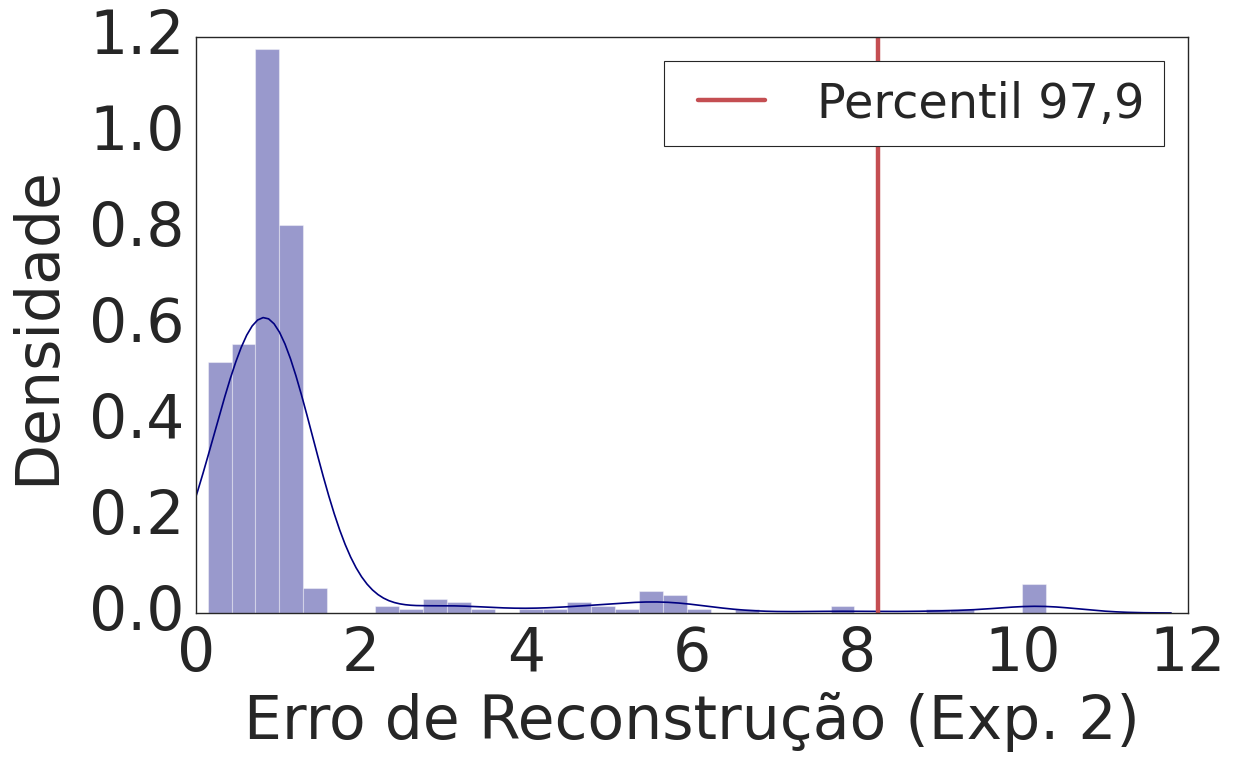

In [ ]:
fsize=54
sns.set_style(style='white')

scored_train = pd.DataFrame()
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-x_train), axis = 1)

plt.figure(figsize=(16,9), dpi=80)
sns.distplot(scored_train['Loss_mae'], bins = 35, kde=True, color = 'navy')
plt.axvline(x=threshold, linewidth=4, color="r", label="Percentil 97,9")
plt.legend(fontsize=fsize-11, loc="upper right", framealpha=1)
sns.set(font_scale=1.4)

plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.xlim([0.0,12])
plt.xlabel("Erro de Reconstrução (Exp. 2)", fontsize=fsize, labelpad=8.0)
plt.ylabel("Densidade", fontsize=fsize, labelpad=20)

plt.savefig("dist.pdf", bbox_inches="tight", transparent=True)